# PhotoMatching Project

Мне было поручено разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from transformers import BertModel, BertTokenizer

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ImageOpening Module
from PIL import Image
import os
import requests
from io import BytesIO

# стиль для бэкграунда графиков

sns.set_style('darkgrid')

# фиксирую значение генератора псевдослучайности
np.random.seed(333)

# константа папки хранящей данные для проекта
DATA_PATH = '/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data'

## Исследовательский анализ данных

### Эксперты

In [2]:
# данные оценок экспертов
col_names = ['image', 'query_id', 'Expert_1', 'Expert_2', 'Expert_3']
experts_data = pd.read_table(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), header=None, names=col_names)

new_rates = {1: 0, 2: 0.3, 3: 0.6, 4: 1}

experts_data['Expert_1'] = experts_data['Expert_1'].replace(new_rates)
experts_data['Expert_2'] = experts_data['Expert_2'].replace(new_rates)
experts_data['Expert_3'] = experts_data['Expert_3'].replace(new_rates)


experts_data.sample(10)

,image,query_id,Expert_1,Expert_2,Expert_3
4439,3523874798_9ba2fa46e3.jpg,3702436188_2c26192fd0.jpg#2,1.0,1.0,1.0
4809,363617160_6cb0c723be.jpg,317488612_70ac35493b.jpg#2,0.0,0.0,0.0
2004,2667015110_1670324a33.jpg,2251747182_6b67a3ab8b.jpg#2,0.3,0.3,0.3
1612,2510020918_b2ca0fb2aa.jpg,132489044_3be606baf7.jpg#2,0.0,0.0,0.0
3696,3290105461_7590f23371.jpg,3155987659_b9ea318dd3.jpg#2,0.0,0.0,0.3
924,2196316998_3b2d63f01f.jpg,2731171552_4a808c7d5a.jpg#2,0.0,0.0,0.3
5549,540721368_12ac732c6c.jpg,170100272_d820db2199.jpg#2,0.3,0.3,0.3
3000,3107513635_fe8a21f148.jpg,3045613316_4e88862836.jpg#2,0.0,0.0,0.3
5706,758921886_55a351dd67.jpg,758921886_55a351dd67.jpg#2,1.0,1.0,1.0
1846,260520547_944f9f4c91.jpg,2473791980_805c819bd4.jpg#2,0.0,0.0,0.3


In [3]:
def get_consensus(row):
    
    experts_score = [row['Expert_1'], row['Expert_2'], row['Expert_3']]
    score_counts = pd.Series(experts_score).value_counts()
    
    for score, count in score_counts.items():
        if count >= 2:
            return score
        return None
    
experts_data['score'] = experts_data.apply(get_consensus, axis=1)

experts_data = experts_data.dropna()
experts_data.sample(10)

,image,query_id,Expert_1,Expert_2,Expert_3,score
86,1174629344_a2e1a2bdbf.jpg,3365783912_e12c3510d8.jpg#2,0.3,0.3,0.6,0.3
4120,3442242092_e579538d82.jpg,249394748_2e4acfbbb5.jpg#2,0.0,0.0,0.0,0.0
3061,3116769029_f5a76f04ba.jpg,3385246141_a263d1053e.jpg#2,0.0,0.0,0.0,0.0
4080,3432550415_e7b77232de.jpg,2884420269_225d27f242.jpg#2,0.0,0.0,0.3,0.0
166,1287475186_2dee85f1a5.jpg,2393264648_a280744f97.jpg#2,0.0,0.0,0.0,0.0
3521,3244747165_17028936e0.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.3,0.0
1384,2435685480_a79d42e564.jpg,3232470286_903a61ea16.jpg#2,0.0,0.0,0.0,0.0
870,2182488373_df73c7cc09.jpg,1962729184_6996e128e7.jpg#2,0.0,0.0,0.3,0.0
2503,2913965136_2d00136697.jpg,3545652636_0746537307.jpg#2,0.6,0.6,0.6,0.6
2950,3085226474_62aba51179.jpg,2662845514_8620aaee96.jpg#2,0.0,0.0,0.0,0.0


In [4]:
print(f' Количество уникальных запросов {len(experts_data.query_id.unique())}')
print(f' Количество уникальных изображений {len(experts_data.image.unique())}')

 Количество уникальных запросов 977
 Количество уникальных изображений 1000


Для удобства последующей обработки было решено преобразовать оценки экспертов

In [5]:
experts_data.describe()

,Expert_1,Expert_2,Expert_3,score
count,5696.000000,5696.000000,5696.000000,5696.000000
mean,0.136850,0.188904,0.262465,0.188904
std,0.252244,0.273436,0.283783,0.273436
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.300000,0.000000
75%,0.300000,0.300000,0.300000,0.300000
max,1.000000,1.000000,1.000000,1.000000


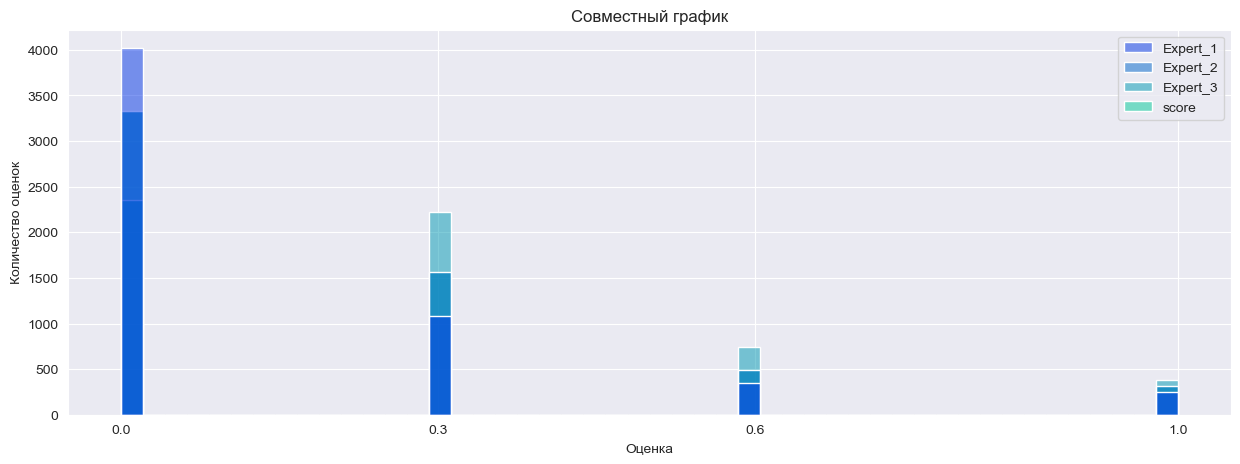

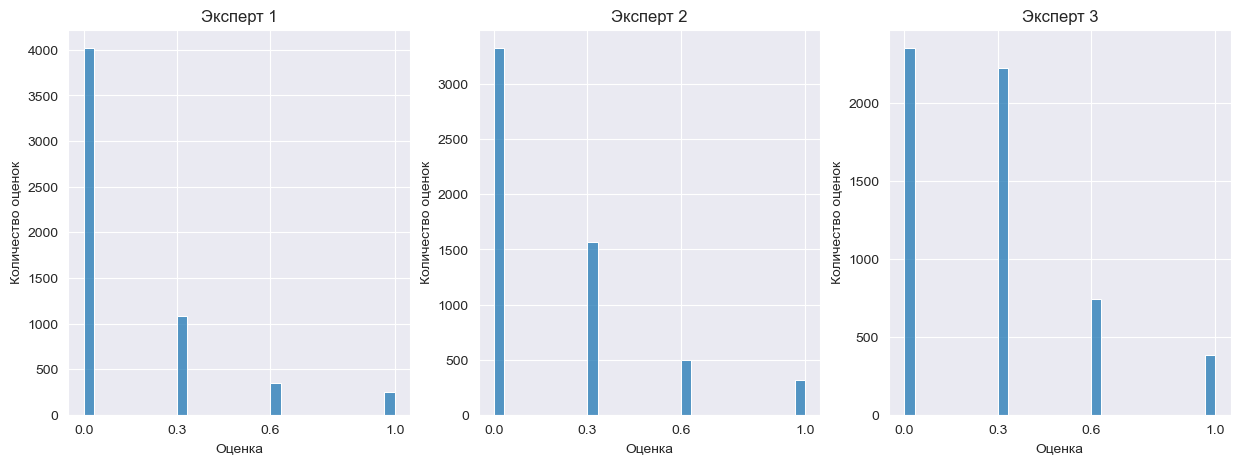

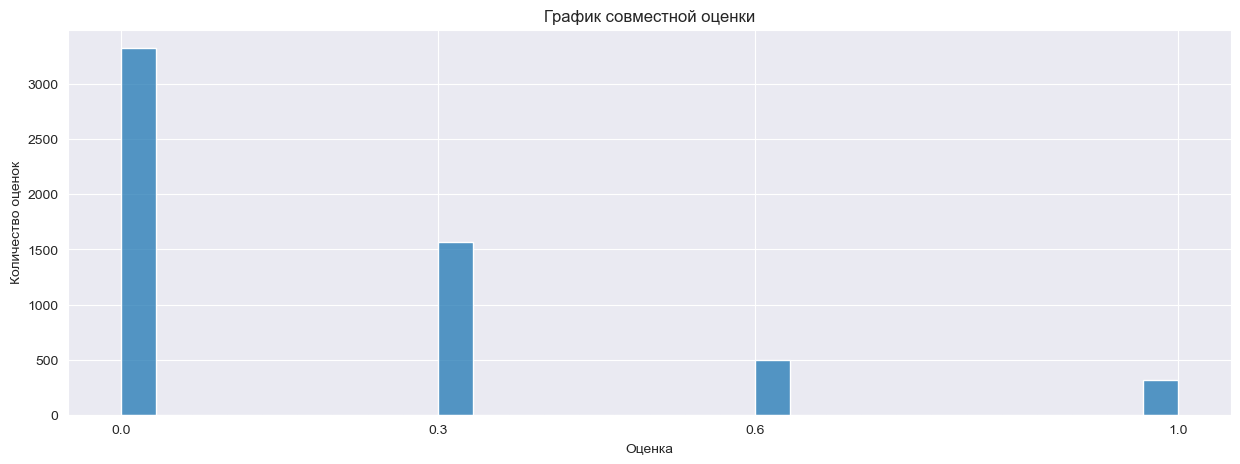

In [6]:
plt.figure(figsize=(15, 5))
plt.title('Совместный график')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data, palette='winter')
plt.xticks([0, 0.3, 0.6, 1])

plt.show()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Эксперт 1')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['Expert_1'])
plt.xticks([0, 0.3, 0.6, 1])

plt.subplot(1, 3, 2)
plt.title('Эксперт 2')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['Expert_2'])
plt.xticks([0, 0.3, 0.6, 1])

plt.subplot(1, 3, 3)
plt.title('Эксперт 3')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['Expert_3'])
plt.xticks([0, 0.3, 0.6, 1])

plt.show()

plt.figure(figsize=(15, 5))
plt.title('График совместной оценки')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['score'])
plt.xticks([0, 0.3, 0.6, 1])

plt.show()

**Вывод по блоку**

Видно что эксперты по разному ставят оценки, у первого эксперта видимо были очень жесткие требования к точности запросов.

Функцией `get_consensus` была получена итоговая оценка экспертов по каждой паре

### Толпа

In [7]:
col_names = ['image', 'query_id', 'crowd_score', 'Yes', 'No']
crowd_data = pd.read_table(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), header=None, names=col_names)
print(crowd_data.describe())
print(crowd_data['crowd_score'].unique())
crowd_data

        crowd_score           Yes            No
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000
[1.         0.         0.33333333 0.66666667 0.25       0.6
 0.2        0.5        0.4        0.75       0.16666667 0.8       ]


,image,query_id,crowd_score,Yes,No
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


In [8]:
print(f' Количество уникальных запросов {len(crowd_data.query_id.unique())}')
print(f' Количество уникальных изображений {len(crowd_data.image.unique())}')

 Количество уникальных запросов 1000
 Количество уникальных изображений 1000


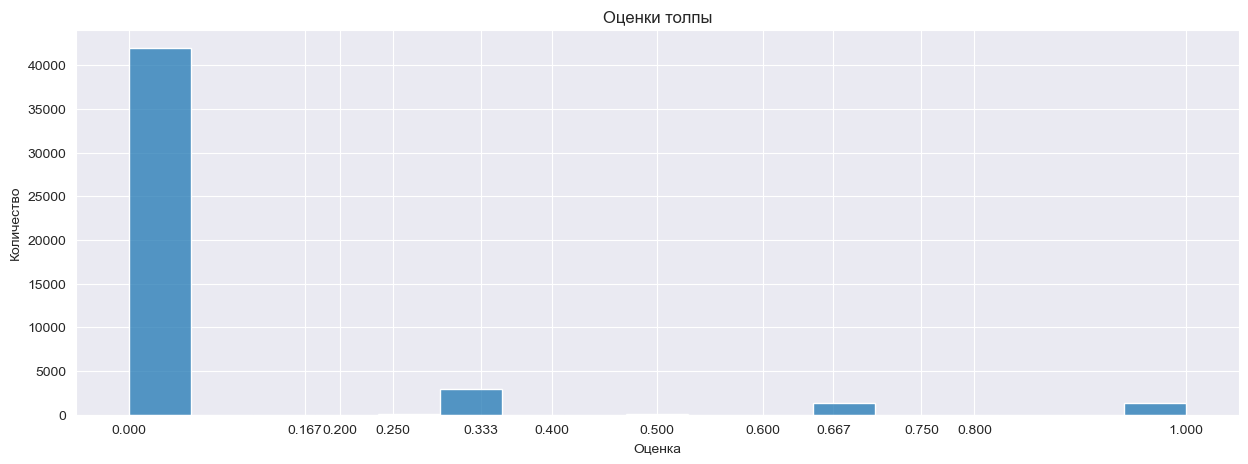

In [9]:
plt.figure(figsize=(15, 5))
plt.title('Оценки толпы')
plt.xlabel('Оценка')
plt.ylabel('Количество')
sns.histplot(crowd_data['crowd_score'])
plt.xticks(crowd_data['crowd_score'].unique())

plt.show()

**Вывод по блоку**

Получен датасет с оценками различных комбинаций описаний и картинок

### Тренировочный датасет

In [10]:
train_data = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

train_data.info()
train_data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
4524,3004823335_9b82cbd8a7.jpg,2886411666_72d8b12ce4.jpg#2,"A dog runs through a lush , green lawn ."
533,3584561689_b6eb24dd70.jpg,3459156091_c1879ebe28.jpg#2,A picture of Albert Einstein on a white bear s...
1093,1282392036_5a0328eb86.jpg,3155987659_b9ea318dd3.jpg#2,A dog jumps to catch a red Frisbee in the yard .
5654,3143155555_32b6d24f34.jpg,398662202_97e5819b79.jpg#2,Two babies in sweaters playing with a toy .
2263,1836335410_de8313a64e.jpg,3450874870_c4dcf58fb3.jpg#2,two men sit on a chairlift .
922,3657016761_d553e514d9.jpg,1131800850_89c7ffd477.jpg#2,A furry dog attempts to dry itself by shaking ...
2009,1472230829_803818a383.jpg,1472230829_803818a383.jpg#2,Rafting boat on river .
3886,3281078518_630a7a7f4f.jpg,3692593096_fbaea67476.jpg#2,A small plane is dropping a red chemical over ...
2998,2096771662_984441d20d.jpg,3145967309_b33abe4d84.jpg#2,A man in a white print shirt and a woman in a ...
3434,3270691950_88583c3524.jpg,2860872588_f2c7b30e1a.jpg#2,Two dogs are jumping up at each other .


In [11]:
print(f' Количество уникальных запросов {len(train_data.query_text.unique())}')
print(f' Количество уникальных изображений {len(train_data.image.unique())}')

 Количество уникальных запросов 977
 Количество уникальных изображений 1000


### Тестовый датасет

In [12]:
t_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'),
                        delimiter='|', index_col='Unnamed: 0')
t_queries.sample(10)

,query_id,query_text,image
400,3601978895_9fec23ce0c.jpg#0,a man leans against a large robot .,3601978895_9fec23ce0c.jpg
399,3555573680_41c1540a86.jpg#4,A man waterskiing through the air near a dock .,3555573680_41c1540a86.jpg
224,3089107423_81a24eaf18.jpg#4,The man in the black shirt is pointing his cam...,3089107423_81a24eaf18.jpg
47,191003283_992257f835.jpg#2,A woman walks and a little boy walks to the si...,191003283_992257f835.jpg
489,973827791_467d83986e.jpg#4,I child slides into a wading pool full of wate...,973827791_467d83986e.jpg
40,186346360_541047336f.jpg#0,A girl in a bikini top and shorts poses for a ...,186346360_541047336f.jpg
165,2714674623_8cd05ac114.jpg#0,a large man dozes off on the bus .,2714674623_8cd05ac114.jpg
64,2107838729_a527e434bd.jpg#4,Little boy standing on the bank of a river .,2107838729_a527e434bd.jpg
290,3330333217_1a69497a74.jpg#0,A black man in a blue shirt stands next to a b...,3330333217_1a69497a74.jpg
381,3517023411_a8fbd15230.jpg#1,a biker rides down the street .,3517023411_a8fbd15230.jpg


In [13]:
print(f' Количество уникальных запросов {len(t_queries.query_text.unique())}')
print(f' Количество уникальных изображений {len(t_queries.image.unique())}')

 Количество уникальных запросов 500
 Количество уникальных изображений 100


Проанализировав данные можно сделать вывод, что мы имеем дело всего лишь с 1000 уникальных картинок и 1000 уникальных запросов.

Следовательно нужно получить лишь по 1000 эмбедингов, а далее просто их правильно комбинировать.

Так же видно, что оценок толпы почти в 9 раз больше чем оценок экспертов. Возможно в будущем нужно будет рассмотреть несколько стратегий работы с данными

### Подготовка тренировочного датасета

In [14]:
query = train_data[['query_id', 'query_text']].drop_duplicates()
query[query['query_id'] == '543007912_23fc735b99.jpg#2']

,query_id,query_text
571,543007912_23fc735b99.jpg#2,Two girls with orange shirts .


### изменение подхода к использованию данных

In [15]:
# train = pd.merge(crowd_data, train_data, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='left')
# train = pd.merge(train, experts_data, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='left')
# train = pd.merge(train, query, on='query_id', how='left', suffixes=('', '_from_train'))
# train['query_text'] = train['query_text'].combine_first(train['query_text_from_train'])
# train.drop(columns=['query_text_from_train'], inplace=True)
# train

In [16]:
train = pd.merge(experts_data, train_data, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='left')
train

,image,query_id,Expert_1,Expert_2,Expert_3,score,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.3,0.0,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0,0.0,0.3,0.0,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0,0.3,0.3,0.3,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.0,0.0,0.3,0.0,Chinese market street in the winter time .
...,...,...,...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.0,0.0,0.0,0.0,People trackside at a subway station by a train .
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.0,0.0,0.0,0.0,A man sitting on a subway .
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.0,0.0,0.3,0.0,A man wearing a red hat looks down as another ...
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.0,0.0,0.0,0.0,A white birds lands swiftly in the water .


In [17]:
# train = train[['image', 'query_id', 'crowd_score', 'query_text', 'score']]
train = train[['image', 'query_id', 'query_text', 'score']]
train


,image,query_id,query_text,score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.3
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.0
...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,People trackside at a subway station by a train .,0.0
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,A man sitting on a subway .,0.0
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,A man wearing a red hat looks down as another ...,0.0
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,A white birds lands swiftly in the water .,0.0


In [18]:
# def train_scorer(row):
#     if row['score'] >= 0:
#         row['score'] = (row['score'] * 0.6) + (row['crowd_score'] * 0.4)
#     else:
#         row['score'] = row['crowd_score']
#     return row
        
# train = train.apply(train_scorer, axis=1)
# train = train.dropna()

In [19]:
train

,image,query_id,query_text,score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.3
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.0
...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,People trackside at a subway station by a train .,0.0
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,A man sitting on a subway .,0.0
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,A man wearing a red hat looks down as another ...,0.0
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,A white birds lands swiftly in the water .,0.0


In [20]:
train['score'].value_counts()

score
0.0    3327
0.3    1566
0.6     492
1.0     311
Name: count, dtype: int64

Видна огромная разница в количестве нулевых значений и всех других

**Вывод по блоку**

Получен большой датасет сформированный по такому принципу - поэтапно соединены датасеты `crowd_data + train_data + experts_data` в итоге был получен комбинированный датасет `train`, далее были дополнены пропущенные тексты описаний и вычислена итоговая оценка по комбинации изображения и описания как оценка толпы (если нет оценки экспертов) и оценка экспертов с весом 0.6 и оценка топлы с весом 0.4

### Модуль цензуры

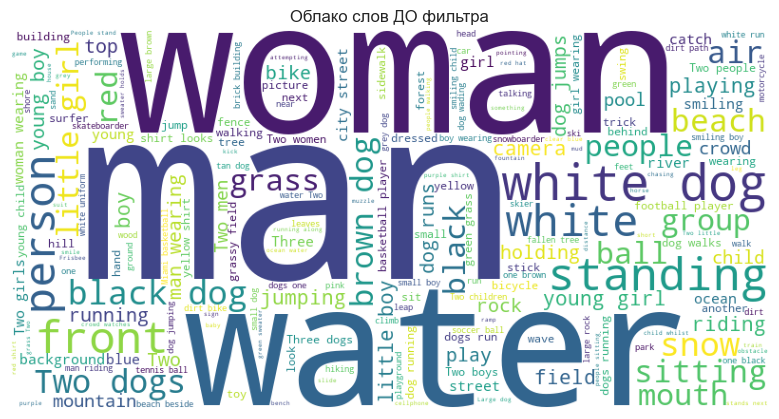

In [21]:
df = train
corpus = ' '.join(df['query_text'].astype(str).values)

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(corpus)



plt.figure(figsize = (8, 4), facecolor = None)
plt.title('Облако слов ДО фильтра')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [22]:
stop_law = ['boy', 'baby', 'boys', 'girl', 'girls', 'teen', 'teens', 'child', 'children', 'toddler', 'young', 'kid', 'kids']

def censoring(line, stop_law, column=None):
    for word in stop_law:
        if word in line:
            return None
    return line

train['query_text'] = train['query_text'].apply(lambda x: censoring(x, stop_law))#, 'query_text'))
train = train.dropna()

/var/folders/sd/g9y3t5556kv1b3z_d62zpfs80000gn/T/ipykernel_46901/4165783181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['query_text'] = train['query_text'].apply(lambda x: censoring(x, stop_law))#, 'query_text'))


In [23]:
train

,image,query_id,query_text,score
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.3
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.0
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,A soccer ball is above the head of a man weari...,0.0
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.0
...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,People trackside at a subway station by a train .,0.0
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,A man sitting on a subway .,0.0
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,A man wearing a red hat looks down as another ...,0.0
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,A white birds lands swiftly in the water .,0.0


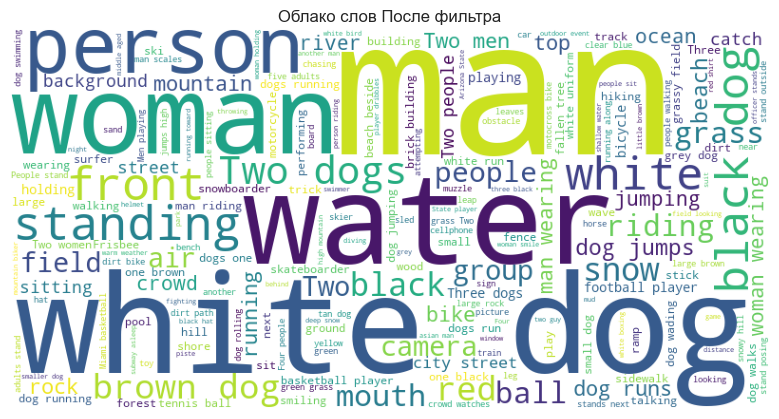

In [24]:
df = train
corpus = ' '.join(df['query_text'].astype(str).values)

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(corpus)



plt.figure(figsize = (8, 4), facecolor = None)
plt.title('Облако слов После фильтра')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

**Вывод**

Цензура сработала как нужно и теперь нет нежелательных описаний в тренировочных данных
Для наглядности работы цензуры были построены 2 графика облака слов ДО и ПОСЛЕ проверки данных цензурным модулем

## Получение эмбеддингов

### Эмбеддинги изображений

In [25]:
#train['image'].unique()
len(train['query_text'].unique())

685

In [26]:

def get_image_embeddings(df, file_name):
    
    unique_img_list = df['image'].unique()
    unique_image_paths = [os.path.join(DATA_PATH, file_name)\
               + image_name for image_name in unique_img_list]
    # пустой список для эмбеддингов
    embeddings = []
    
    #загрузчик данных
    loader = DataLoader(unique_image_paths, batch_size=1, shuffle=True)
    
    # моделька ResNet18
    resnet = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    for params in resnet.parameters():
        params.requires_grad_(False)
        
    #испольщование только светочных слоев
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)
    resnet.eval()
    
    #подготовительное преобразование
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm
    ])
    
    #формирование батчей
    for batch in tqdm(loader):
        batch_images = []
        for path in batch:
            img = Image.open(path).convert('RGB')
            image_tensor = preprocess(img)
            batch_images.append(image_tensor)
            
        batch_images = torch.stack(batch_images)
        
        #преобразование батча в эмбеддинги
        with torch.no_grad():
            batch_embeddings = resnet(batch_images)#.squeeze() вернуть при возобновлении обучения по батчам
        for emb in batch_embeddings:
            embeddings.append(emb.flatten().cpu().numpy())
    
    # подставка данных на их места
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    img_to_embedding = dict(zip(unique_img_list, embeddings))
    img_df = df.copy()
    img_df.loc[:, 'embeddings'] = img_df['image'].map(img_to_embedding)
    img_embeddings = np.array(img_df['embeddings'].to_list())
    return img_embeddings

def get_text_embeddings(df):
    queries = df['query_text'].unique()
    #queries = df['query_text'].to_list()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    embeddings = []
    for query in tqdm(queries):
        inputs = tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=128)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(embedding.flatten())
#     return np.array(embeddings)
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    query_to_embedding = dict(zip(queries, embeddings))
    query_df = df
    query_df.loc[:, 'embeddings'] = query_df['query_text'].map(query_to_embedding)
    text_embeddings = np.array(query_df['embeddings'].to_list())
    return text_embeddings

def combine_embeddings(img_embeddings, text_embeddings):    
    combined_embeddings = np.concatenate([img_embeddings, text_embeddings], axis=1)
    return combined_embeddings

# Пример вызова функций

img_embeddings = get_image_embeddings(train, 'train_images/')

text_embeddings = get_text_embeddings(train)


print(f"Размерность эмбеддингов изображений: {img_embeddings.shape}")  # Ожидаем (34027, 512)
print(f"Размерность эмбеддингов текста: {text_embeddings.shape}")  # Ожидаем (34027, 768)



# Объединим эмбеддинги
combined_embeddings = combine_embeddings(img_embeddings, text_embeddings)
print(f"Размерность объединённых эмбеддингов: {combined_embeddings.shape}")  # Ожидаем (34027, 1280)


100%|█████████████████████████████████████████| 993/993 [00:10<00:00, 92.44it/s]


(993, 512)


100%|█████████████████████████████████████████| 685/685 [00:16<00:00, 40.53it/s]

(685, 768)
Размерность эмбеддингов изображений: (4158, 512)
Размерность эмбеддингов текста: (4158, 768)
Размерность объединённых эмбеддингов: (4158, 1280)



/var/folders/sd/g9y3t5556kv1b3z_d62zpfs80000gn/T/ipykernel_46901/375469630.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df.loc[:, 'embeddings'] = query_df['query_text'].map(query_to_embedding)


In [27]:
text_embeddings

array([[ 0.2259459 , -0.14776978, -0.4104262 , ..., -0.3192073 ,
         0.43000948,  0.24305414],
       [ 0.3637197 ,  0.1630092 , -0.4905527 , ..., -0.30124572,
         0.1486541 ,  0.3463124 ],
       [-0.3684233 , -0.23577404, -0.3058007 , ..., -0.5351161 ,
         0.49860504,  0.07659721],
       ...,
       [ 0.3069551 ,  0.4810696 , -0.01968053, ..., -0.27771607,
         0.2682139 ,  0.6329777 ],
       [-0.09270298,  0.39325655, -0.04232742, ..., -0.1641497 ,
         0.12132661,  0.4290649 ],
       [-0.50136465,  0.10107128, -0.5446709 , ..., -0.13422373,
         0.14601383,  0.250716  ]], dtype=float32)

In [28]:
combined_embeddings = pd.DataFrame(combined_embeddings)
train_data = combined_embeddings
train_data['target'] = train['score'].values[:]

#train_data['group'] = np.where(np.random.rand(len(train_data)) < 0.3, 1, 0)
train_data.sample(10) # изменить тут

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,target
3784,0.002502,0.116984,1.336501,0.551801,1.950274,0.245238,1.722484,3.437928,0.229400,3.409761,...,-0.131837,-0.143946,-0.215601,0.167112,0.980792,0.195341,-0.240912,0.270402,0.030627,0.3
3409,1.460858,1.190942,1.475550,0.642737,0.547282,1.052266,0.116786,1.408113,0.336312,0.359015,...,-0.035701,-0.644442,0.209470,0.402343,0.184115,-0.478831,-0.152585,0.523466,-0.241142,0.3
2408,0.112467,2.251286,0.083233,0.560250,0.160197,0.317539,0.138482,1.193959,2.716103,0.068715,...,-0.045417,-0.158240,-0.214286,0.307322,0.095849,-0.453346,-0.469997,0.335383,-0.089274,0.6
3499,0.368128,0.412350,1.110677,0.534202,0.055609,2.433829,0.714955,2.892505,1.847895,0.912331,...,0.182008,-0.230049,-0.084329,-0.020390,0.619914,0.024971,-0.110899,0.258271,0.375028,0.3
3326,0.459238,0.102698,0.663127,1.127232,1.800625,0.000000,1.074558,3.351000,0.826965,4.207392,...,0.528882,0.084109,0.195386,0.106893,0.515840,0.105526,-0.257886,0.674431,0.366552,0.3
290,0.918736,0.848977,0.905874,0.193960,0.091838,0.460851,0.086701,0.366684,1.260458,0.040973,...,-0.129917,-0.564781,-0.035660,0.276746,0.229873,-0.814682,-0.058955,0.265641,-0.339022,0.0
2281,0.608258,1.398964,0.173323,0.076558,0.585676,0.029646,0.251997,0.261543,0.648833,0.181507,...,-0.068606,-0.225345,-0.129188,-0.108463,0.682304,0.415086,-0.347965,0.085664,-0.206924,0.0
574,0.942778,0.784685,1.625962,1.288515,2.617470,0.192211,0.375114,0.238970,0.460728,1.055114,...,0.153755,-0.214954,-0.081328,0.197444,0.414959,0.169886,-0.024601,0.466433,0.076409,0.3
4153,0.034505,1.069734,1.786919,1.011996,0.396039,1.260745,1.620791,0.164577,0.804514,1.838551,...,-0.273826,0.076364,-0.206111,0.356361,0.791323,-0.069625,-0.459692,0.293384,0.187597,0.0
1770,0.803040,0.196062,1.098910,0.822830,0.496877,1.737589,0.256550,1.304651,0.080077,0.172630,...,-0.308343,-0.066746,0.363346,0.544531,0.884637,0.306379,-0.221607,0.095923,0.363660,0.3


In [29]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=333)
gss.get_n_splits()

train_indeses, valid_indises = next(gss.split(X=train_data.drop(columns=['target']),
                                              y=train_data['target'],
                                              groups=train['image']))
train_df, valid_df = train_data.loc[train_indeses], train_data.loc[valid_indises]

train_df.sample(10)

# train_df = train_df[train_df['target']>= 1]

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,target
4104,0.744311,0.639973,0.182162,0.472726,2.439409,1.885510,1.260631,8.911119,0.658387,0.401533,...,0.386497,-0.226671,-0.044846,-0.045942,0.811515,0.184121,-0.101373,0.176423,0.442939,0.0
3454,0.345215,0.448793,1.674436,1.136729,0.211295,0.808835,0.631095,0.420492,1.233347,0.669663,...,0.002288,-0.101312,-0.073315,0.299376,1.078456,0.369179,-0.080849,0.083026,0.399318,0.0
2942,0.266219,1.564111,0.626641,0.986740,0.388947,0.232031,0.250943,0.217954,0.490318,0.323707,...,0.013166,0.025567,-0.114109,0.119166,1.003929,-0.021667,-0.068571,0.437769,0.087455,0.0
3320,1.046005,0.154947,0.151775,1.697244,0.043135,0.196139,0.398041,4.169639,0.241179,0.222588,...,0.165981,-0.007477,0.143439,0.078226,0.344372,0.103162,-0.259692,0.414690,0.089008,0.0
169,1.924109,1.793320,1.158756,1.332239,0.280507,1.484600,0.011293,1.472856,0.668250,0.532342,...,-0.243064,-0.353826,-0.170759,0.235248,0.422646,-0.570990,-0.467179,0.244884,-0.260268,0.3
571,0.154095,0.232715,0.351846,0.392621,0.445059,0.032276,0.853934,0.473060,0.199643,0.775653,...,-0.298936,-0.382262,-0.000231,0.403267,0.604864,-0.355073,-0.134432,0.346378,-0.053333,0.0
2381,0.861890,0.382990,0.606586,0.269388,0.300852,0.162871,0.322857,3.620435,0.774223,0.635968,...,0.386497,-0.226671,-0.044846,-0.045942,0.811515,0.184121,-0.101373,0.176423,0.442939,0.3
177,0.342645,1.503999,1.402282,0.105094,0.029774,1.013788,0.835008,0.728387,1.718704,0.000000,...,0.208643,-0.104767,0.041948,0.008680,0.474928,-0.036736,-0.159173,0.367882,0.419644,0.3
4157,0.034505,1.069734,1.786919,1.011996,0.396039,1.260745,1.620791,0.164577,0.804514,1.838551,...,-0.375804,0.185102,-0.256894,0.386479,0.700431,0.507243,-0.134224,0.146014,0.250716,0.6
464,0.634589,0.778725,0.083717,0.737584,0.402394,0.284960,0.336335,3.942270,0.024408,1.202943,...,-0.323320,0.009057,-0.355160,0.196788,0.979726,0.047154,-0.264533,0.198871,0.137650,0.3


In [30]:
model_l = LinearRegression()

X = train_df.drop(['target'], axis=1)
y = train_df['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

model_l.fit(X, y)


X_valid = valid_df.drop(['target'], axis=1)
y_valid = valid_df['target']

X_valid = scaler.transform(X_valid)

X_preds = model_l.predict(X)
X_val_preds = model_l.predict(X_valid)


sklearn_linear_train_mae = mean_absolute_error(y, X_preds)
sklearn_linear_valid_mae = mean_absolute_error(y_valid, X_val_preds)
print(mean_absolute_error(y, X_preds))
print(mean_absolute_error(y_valid, X_val_preds))



0.14162405902513464
8.244053814732483


### PyTorch LinearRegression

In [31]:
# перевод данных в Torch tensors
x_train_tensor = torch.tensor(train_df.drop(columns=['target']).values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['target'].values.reshape(-1, 1), dtype=torch.float32)
x_valid_tensor = torch.tensor(valid_df.drop(columns=['target']).values, dtype=torch.float32)
y_valid_tensor = torch.tensor(valid_df['target'].values.reshape(-1, 1), dtype=torch.float32)

In [32]:
print(f'Size of x_valid_tensor: {x_valid_tensor.size()}')
print(f'Size of y_valid_tensor: {y_valid_tensor.size()}')


# Архитектура модели
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(x_train_tensor.shape[1], 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Инициализация параметров
c_l_model = LinearRegressionModel()
criterion = nn.L1Loss()
optimizer = optim.Adam(c_l_model.parameters(), lr=0.00001)
num_epochs = 10000

# списки хранения
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    # прямой проход
    c_l_model.train()
    outputs = c_l_model(x_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    # обратный проход
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # добавление значения функции потерь трейна
    train_losses.append(train_loss.item())
    
    # валидация
    
    # режим предсказаний
    c_l_model.eval()
    
    # отключение записи градиентов
    with torch.no_grad():
        
        outputs = c_l_model(x_valid_tensor)
        val_loss = criterion(outputs, y_valid_tensor)
        
        # добавление значения функции потерь валидации
        valid_losses.append(val_loss.item())
    
    if (epoch+1) % 100 == 0:
        
        print(f'Epoch [{epoch+1} / {num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
print('Обучение завершено')


    
c_l_predicted_train = c_l_model(x_train_tensor).detach().numpy()
c_l_predicted_valid = c_l_model(x_valid_tensor).detach().numpy()

custom_linear_train_mae = round(train_loss.item(), 2)
custom_linear_val_mae = round(val_loss.item(), 2)

Size of x_valid_tensor: torch.Size([1228, 1280])
Size of y_valid_tensor: torch.Size([1228, 1])
Epoch [100 / 10000], Train Loss: 0.2938, Val Loss: 0.2929
Epoch [200 / 10000], Train Loss: 0.2445, Val Loss: 0.2480
Epoch [300 / 10000], Train Loss: 0.2320, Val Loss: 0.2375
Epoch [400 / 10000], Train Loss: 0.2267, Val Loss: 0.2331
Epoch [500 / 10000], Train Loss: 0.2231, Val Loss: 0.2302
Epoch [600 / 10000], Train Loss: 0.2202, Val Loss: 0.2279
Epoch [700 / 10000], Train Loss: 0.2176, Val Loss: 0.2261
Epoch [800 / 10000], Train Loss: 0.2154, Val Loss: 0.2244
Epoch [900 / 10000], Train Loss: 0.2135, Val Loss: 0.2230
Epoch [1000 / 10000], Train Loss: 0.2119, Val Loss: 0.2218
Epoch [1100 / 10000], Train Loss: 0.2106, Val Loss: 0.2208
Epoch [1200 / 10000], Train Loss: 0.2094, Val Loss: 0.2199
Epoch [1300 / 10000], Train Loss: 0.2084, Val Loss: 0.2191
Epoch [1400 / 10000], Train Loss: 0.2076, Val Loss: 0.2184
Epoch [1500 / 10000], Train Loss: 0.2068, Val Loss: 0.2179
Epoch [1600 / 10000], Train L

In [33]:


# Архитектура модели с dropout
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_prob=0.5):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Нормализация данных
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_tensor)
x_valid_scaled = scaler.transform(x_valid_tensor)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid_scaled, dtype=torch.float32)

# Инициализация модели
input_dim = x_train_tensor.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
dropout_prob = 0.7
f_model = FeedForwardNN(input_dim, hidden_dim1, hidden_dim2, dropout_prob)
criterion = nn.L1Loss()
optimizer = optim.Adam(f_model.parameters(), lr=0.001)
num_epochs = 40000

# Списки для хранения потерь
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Прямой проход
    f_model.train()
    outputs = f_model(x_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    # Обратный проход
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Добавление значения функции потерь для обучения
    train_losses.append(train_loss.item())
    
    # Валидация
    f_model.eval()
    with torch.no_grad():
        outputs = f_model(x_valid_tensor)
        val_loss = criterion(outputs, y_valid_tensor)
        
        # Добавление значения функции потерь для валидации
        valid_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1} / {num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print('Обучение завершено')

# Предсказания
f_predicted_train = f_model(x_train_tensor).detach().numpy()
f_predicted_valid = f_model(x_valid_tensor).detach().numpy()

FFNN_train_mae = round(train_loss.item(), 2)
FFNN_val_mae = round(val_loss.item(), 2)

Epoch [100 / 40000], Train Loss: 0.1447, Val Loss: 0.1935
Epoch [200 / 40000], Train Loss: 0.1145, Val Loss: 0.1992
Epoch [300 / 40000], Train Loss: 0.1024, Val Loss: 0.2036
Epoch [400 / 40000], Train Loss: 0.0943, Val Loss: 0.2035
Epoch [500 / 40000], Train Loss: 0.0892, Val Loss: 0.2030
Epoch [600 / 40000], Train Loss: 0.0870, Val Loss: 0.2022
Epoch [700 / 40000], Train Loss: 0.0833, Val Loss: 0.2017
Epoch [800 / 40000], Train Loss: 0.0817, Val Loss: 0.2034
Epoch [900 / 40000], Train Loss: 0.0800, Val Loss: 0.2022
Epoch [1000 / 40000], Train Loss: 0.0792, Val Loss: 0.2042
Epoch [1100 / 40000], Train Loss: 0.0759, Val Loss: 0.2051
Epoch [1200 / 40000], Train Loss: 0.0765, Val Loss: 0.2038
Epoch [1300 / 40000], Train Loss: 0.0751, Val Loss: 0.2039
Epoch [1400 / 40000], Train Loss: 0.0744, Val Loss: 0.2040
Epoch [1500 / 40000], Train Loss: 0.0726, Val Loss: 0.2058
Epoch [1600 / 40000], Train Loss: 0.0685, Val Loss: 0.2067
Epoch [1700 / 40000], Train Loss: 0.0704, Val Loss: 0.2051
Epoch 

In [37]:
# Архитектура модели с увеличенной глубиной
class DeepFeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, dropout_prob=0.3):
        super(DeepFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.fc6 = nn.Linear(hidden_dim5, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc6(x))
        return x

# Нормализация данных
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_tensor)
x_valid_scaled = scaler.transform(x_valid_tensor)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid_scaled, dtype=torch.float32)

# Инициализация модели
input_dim = x_train_tensor.shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 16
dropout_prob = 0.9
d_model = DeepFeedForwardNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, dropout_prob)

criterion = nn.L1Loss()
optimizer = optim.Adam(d_model.parameters(), lr=0.0001)
num_epochs = 40000

# Списки для хранения потерь
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Прямой проход
    d_model.train()
    outputs = d_model(x_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    # Обратный проход
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Добавление значения функции потерь для обучения
    train_losses.append(train_loss.item())
    
    # Валидация
    d_model.eval()
    with torch.no_grad():
        outputs = d_model(x_valid_tensor)
        val_loss = criterion(outputs, y_valid_tensor)
        
        # Добавление значения функции потерь для валидации
        valid_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1} / {num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print('Обучение завершено')

# Предсказания
d_predicted_train = d_model(x_train_tensor).detach().numpy()
d_predicted_valid = d_model(x_valid_tensor).detach().numpy()

DFFNN_train_mae = round(train_loss.item(), 2)
DFFNN_val_mae = round(val_loss.item(), 2)

Epoch [100 / 40000], Train Loss: 0.3362, Val Loss: 0.3387
Epoch [200 / 40000], Train Loss: 0.3183, Val Loss: 0.3282
Epoch [300 / 40000], Train Loss: 0.3139, Val Loss: 0.3168
Epoch [400 / 40000], Train Loss: 0.3046, Val Loss: 0.3040
Epoch [500 / 40000], Train Loss: 0.2997, Val Loss: 0.2885
Epoch [600 / 40000], Train Loss: 0.2926, Val Loss: 0.2718
Epoch [700 / 40000], Train Loss: 0.2874, Val Loss: 0.2540
Epoch [800 / 40000], Train Loss: 0.2802, Val Loss: 0.2392
Epoch [900 / 40000], Train Loss: 0.2832, Val Loss: 0.2290
Epoch [1000 / 40000], Train Loss: 0.2759, Val Loss: 0.2226
Epoch [1100 / 40000], Train Loss: 0.2638, Val Loss: 0.2178
Epoch [1200 / 40000], Train Loss: 0.2665, Val Loss: 0.2124
Epoch [1300 / 40000], Train Loss: 0.2602, Val Loss: 0.2083
Epoch [1400 / 40000], Train Loss: 0.2552, Val Loss: 0.2051
Epoch [1500 / 40000], Train Loss: 0.2617, Val Loss: 0.2029
Epoch [1600 / 40000], Train Loss: 0.2543, Val Loss: 0.2012
Epoch [1700 / 40000], Train Loss: 0.2502, Val Loss: 0.2000
Epoch 

Усложненная архитектура модели не улучшает метрику

In [38]:
custom_linear_train_mae = mean_absolute_error(y_train_tensor.numpy(), c_l_predicted_train)
custom_linear_val_mae = mean_absolute_error(y_valid_tensor.numpy(), c_l_predicted_valid)

FFNN_train_mae = mean_absolute_error(y_train_tensor.numpy(), f_predicted_train)
FFNN_val_mae = mean_absolute_error(y_valid_tensor.numpy(), f_predicted_valid)

DFFNN_train_mae = mean_absolute_error(y_train_tensor.numpy(), d_predicted_train)
DFFNN_val_mae = mean_absolute_error(y_valid_tensor.numpy(), d_predicted_valid)


In [39]:
data = {'model': ['sklearn_LinearRegression', 'custom_LinearRegression', 'FeedForwardNN', 'DeepFeedForwardNN'],
        'train_score': [sklearn_linear_train_mae, custom_linear_train_mae, FFNN_train_mae, DFFNN_train_mae],
        'validation_score': [sklearn_linear_valid_mae, custom_linear_val_mae, FFNN_val_mae, DFFNN_val_mae]}
data = pd.DataFrame(data)
data.round(3)

,model,train_score,validation_score
0,sklearn_LinearRegression,0.142,8.244
1,custom_LinearRegression,0.201,0.213
2,FeedForwardNN,0.053,0.209
3,DeepFeedForwardNN,0.124,0.193


Как видно из таблицы, лучший результат показывает `FeedForwardNN` модель (возможно не заметно, из-за округления), но она лишь на тысячную уступает `DeepFeedForwardNN`, но FFNN существенно легче, поэтому разумно использовать ее

## Проверка модели

In [40]:
test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))

test_images_pathes = [os.path.join(DATA_PATH, 'test_images/')\
                   + t_name for t_name in test_images['image']]
test_img_embeddings = get_image_embeddings(test_images, 'test_images/')


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 87.09it/s]

(100, 512)


In [41]:
text_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'),
                        delimiter='|', index_col= 'Unnamed: 0')
text_queries

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


In [42]:
def load_imges(image_paths):
    images = []
    for path in image_paths:
        image = Image.open(path).convert('RGB')
        images.append(image)
    return images

images = test_images_pathes

def text_embedding(query):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    
    inputs = tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    embedding = last_hidden_state[:, 0, :].detach().numpy()
    embedding = embedding.flatten()
#     return np.array(embeddings)
    return np.array(embedding)

In [43]:
banner_url = 'https://i.ytimg.com/vi/0yDLBlBjFXg/maxresdefault.jpg'

In [44]:


def show_banner():
    response = requests.get(banner_url)
    
    img = Image.open(BytesIO(response.content)).convert('RGB')
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

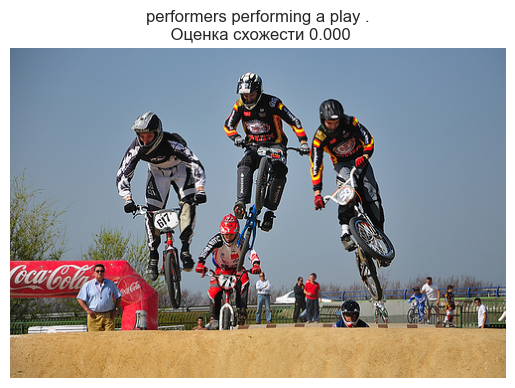

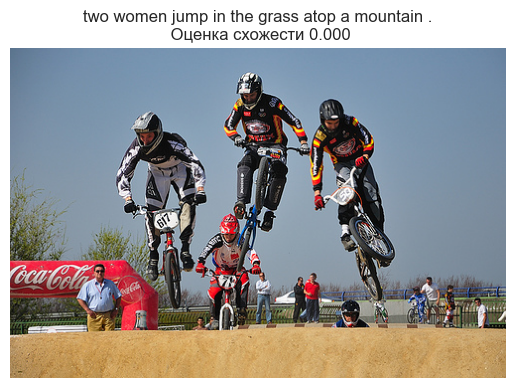

Опасный запрос a girl sitting on the ground in the forest looking through binoculars .


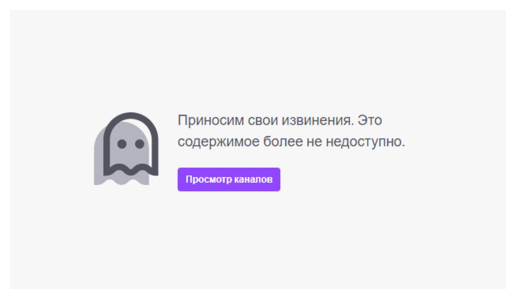

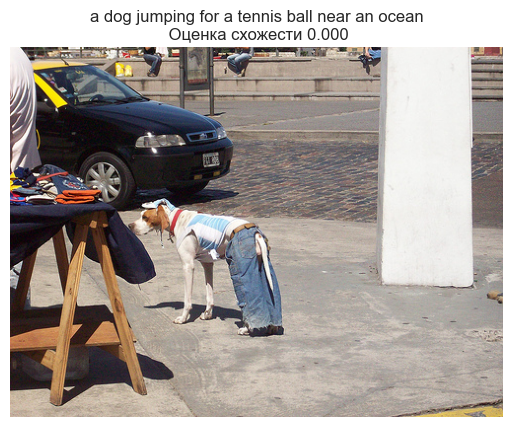

Опасный запрос a large crowd of girls are all wearing green skirts and white tank tops .


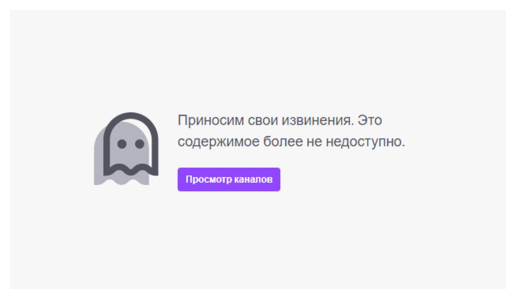

Опасный запрос two little girls in pink outfits play on a yellow and red playground .


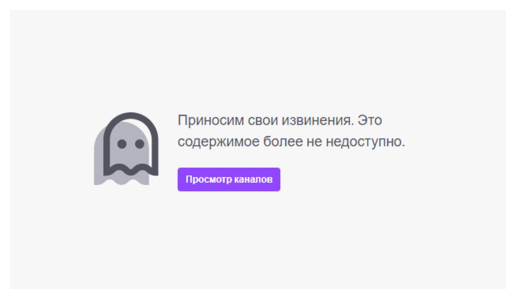

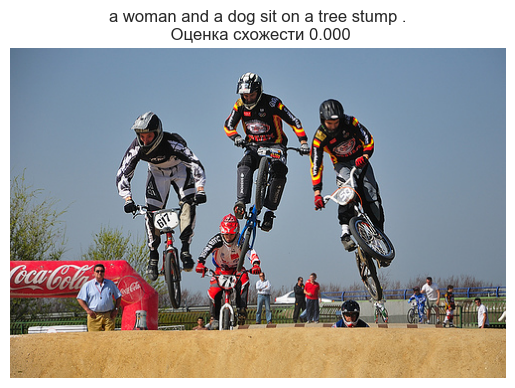

Опасный запрос a young boy is throwing something into a river .


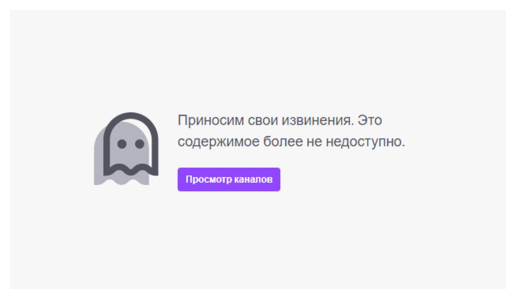

Опасный запрос two kids playing with a dog .


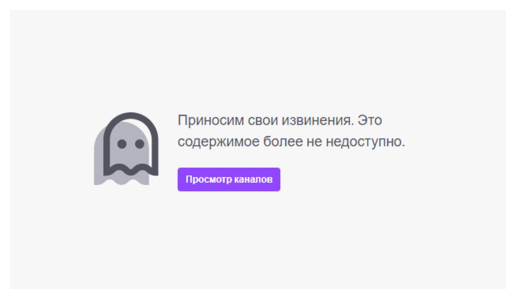

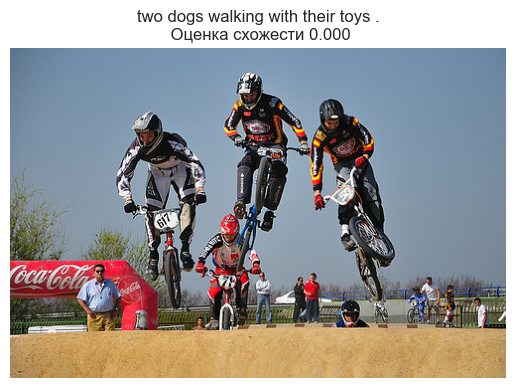

In [46]:
def query_hound(query):
    
    query = query.lower()
    # цензурная проверка
    for word in query.split():
        if word in stop_law:
            print('Опасный запрос', query)
            show_banner()
            return
    # перевод query в эмбеддинг
    
    text_emb= text_embedding(query)
    
    predictions = []
    
    for i_emb in test_img_embeddings:
        
        combined_embedding = np.concatenate([i_emb, text_emb], axis=0)
        combined_tensor = torch.tensor(combined_embedding, dtype = torch.float32)
        
#         prediction = f_model(combined_tensor)
        prediction = d_model(combined_tensor)
        
        prediction = np.array(prediction.detach())
        
        predictions.append(prediction)
        
    similarity = np.max(predictions)
    best_index = np.argmax(predictions)
    
    best_img_path = images[best_index]
    best_img = Image.open(best_img_path).convert('RGB')
    
    plt.imshow(best_img)
    plt.title(f'{query}\n Оценка схожести {similarity:.3f}')
    plt.axis('off')
    plt.show()


#query_hound('Women')

queries = text_queries['query_text'].sample(10).to_list()


for q in queries:
    query_hound(q)

# Вывод

Мною была проделана работа по разработке системы для поиска фотографий по текстовому запросу и оценке схожести текстового описания (запроса) и самой картинки.

Я последовательно выполнил этапы:
- Загрузки данных
- Исследовательского анализа данных
- Разработки системы по превращению картинок и текста в комбинированный эмбеддинг
- Обучение 4 разных моделей
- Демонстрация работы на тестовом датасете

К сожалению алгоритм еще стоит улучшить, так как 0.19 MAE не хватает модели для полноценной работы по сопостовлению картинок между собой. Хотя могу отметить, что первые успехи уже есть и модель нашла фотографию с собакой в запросе со словом "dog" хотя и не совсем верно в контексте, но модель уже подает признаки жизни